## AST 5731 
### Group 1 - Project 1

In [1]:
## Import libraries
import csv
import dis
import inspect
import os
import sys
import time


import astropy
import astroquery
import eleanor
import lightkurve as lk
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import scipy as sp
import scipy.stats as stats
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy.time import TimeDelta
from astropy.timeseries import TimeSeries
from astropy.visualization import time_support
time_support()
from astropy.visualization import quantity_support
quantity_support()

from lightkurve import search_targetpixelfile

from scipy import linalg as la
from scipy import optimize
from scipy import integrate

from scipy.stats import norm
from scipy.stats import beta
from scipy.stats import binom

from IPython.display import display_html
from IPython.display import Image

%matplotlib inline

## set seed for reproducibility
random.seed(5731)

2022-09-29 12:53:56.550055: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-29 12:53:56.703156: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-29 12:53:56.709348: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-29 12:53:56.709364: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

Using Lighkurve, I'll import the data for [Planet TOI-564 b](http://exoplanet.eu/catalog/toi-564_b/), though the .fits files are also located in this repo

In [2]:
## import data with lightkurve
## Note: Guide for doing this can be seen here: https://docs.lightkurve.org/tutorials/1-getting-started/what-are-lightcurve-objects.html
## and here: https://docs.lightkurve.org/tutorials/3-science-examples/exoplanets-recover-first-tess-candidate.html 

tpf_search = search_targetpixelfile('TOI-564 b',  mission='TESS')
print('tpf_search: \n%s \n'%tpf_search)

tpf_search: 
SearchResult containing 4 data products.

 #     mission     year   author  exptime target_name distance
                                     s                 arcsec 
--- -------------- ---- --------- ------- ----------- --------
  0 TESS Sector 08 2019      SPOC     120     1003831      0.0
  1 TESS Sector 08 2019 TESS-SPOC    1800     1003831      0.0
  2 TESS Sector 34 2021      SPOC     120     1003831      0.0
  3 TESS Sector 34 2021 TESS-SPOC     600     1003831      0.0 



We can see that it was observed in both Sectors 8 and 34, so we should download both

I also found that there was no difference between specifying the author between SPOC and TESS-SPOC, so I left out the argument

In [4]:
## create a dictionary of the data, with each key being the sector number
tpf = {sec: search_targetpixelfile('TOI-564 b', mission='TESS',sector=sec).download() for sec in (8,34)}

[print('tpf %s: \n%s \n'%(key,val)) for key,val in tpf.items()]
## Note: tic = 1003831

tpf 8: 
TessTargetPixelFile(TICID: 1003831) 

tpf 34: 
TessTargetPixelFile(TICID: 1003831) 



[None, None]

In [5]:
## some info about the target pixel files
for key, val in tpf.items():
    print('mission: %s'%val.mission)
    print('target: %s'%val.targetid)
    print('sector: %s'%val.sector)
    print('camera: %s'%val.camera)
    print('ccd: %s'%val.ccd)
    print('(ra,dec): (%s , %s)'%(val.ra,val.dec))
    print('time range: %s to %s \n \n'%(val.astropy_time[0],val.astropy_time[-1]))



mission: TESS
target: 1003831
sector: 8
camera: 2
ccd: 4
(ra,dec): (130.295164748118 , -16.036279996188)
time range: 1517.3518290111413 to 1542.0043372886532 
 

mission: TESS
target: 1003831
sector: 34
camera: 2
ccd: 3
(ra,dec): (130.295164748118 , -16.036279996188)
time range: 2228.755299368383 to 2254.0696009699714 
 



tpf 8: 
TessTargetPixelFile(TICID: 1003831) 



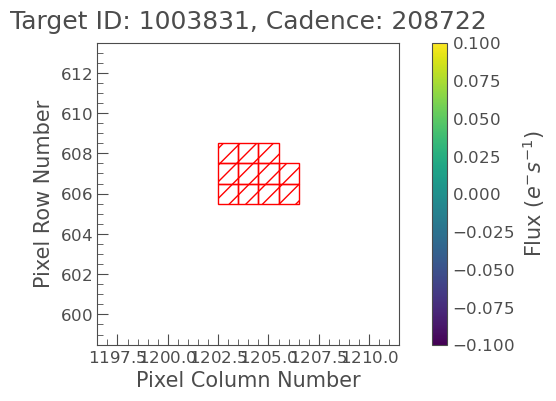

tpf 34: 
TessTargetPixelFile(TICID: 1003831) 



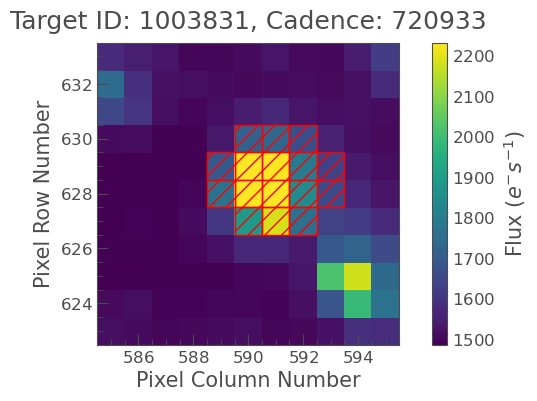

In [7]:
## plot the target pixel files
for key, val in tpf.items():
    print('tpf %s: \n%s \n'%(key,val))
    val.plot(aperture_mask=val.pipeline_mask);
    plt.show(); ## so they show up in the correct order with the print statements

We can see from this that the target pixel file from sector 8 is blank for whatever reason, so we'll just use the one from sector 34 for now

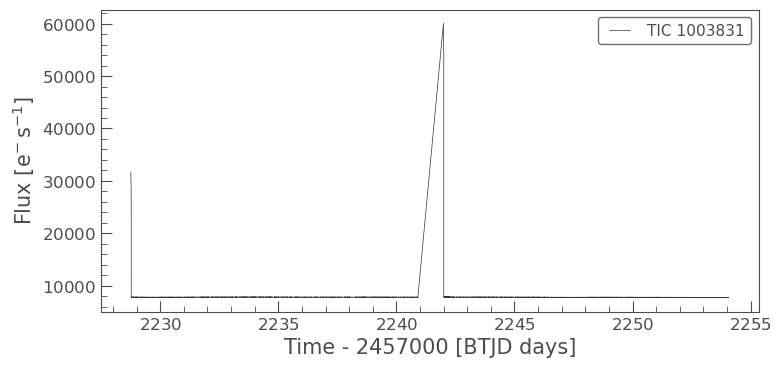

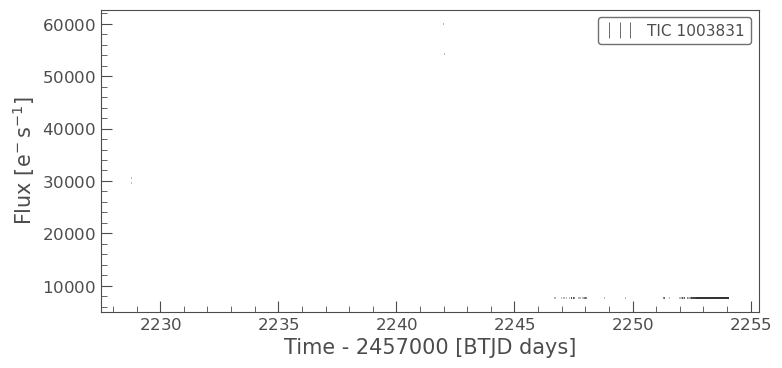

In [8]:
## with that knowledge, define lightcurve to only include the data from sector 34
lc = tpf[34].to_lightcurve()

## plot the lightcurve
lc.plot();
plt.show();
lc.errorbar();
plt.show();

Well those don't look great!

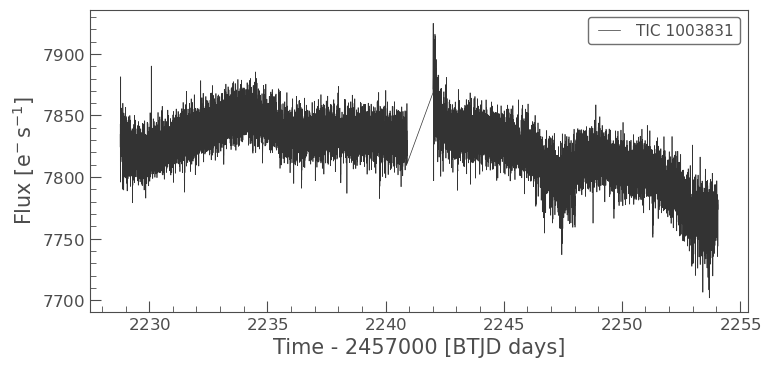

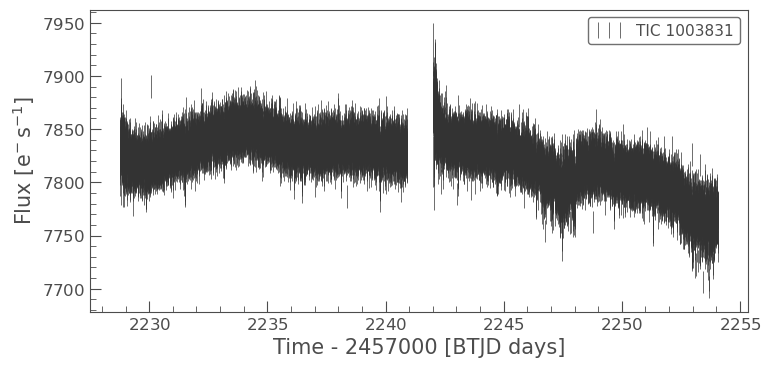

In [12]:
## remove outliers
## Note: See here for info on use of these functions: https://docs.lightkurve.org/tutorials/3-science-examples/exoplanets-recover-first-tess-candidate.html
lc = lc.remove_outliers(sigma=10)
lc.plot();
plt.show();
lc.errorbar();
plt.show();

Those look a lot better!